# Using a neural networt to fit the data

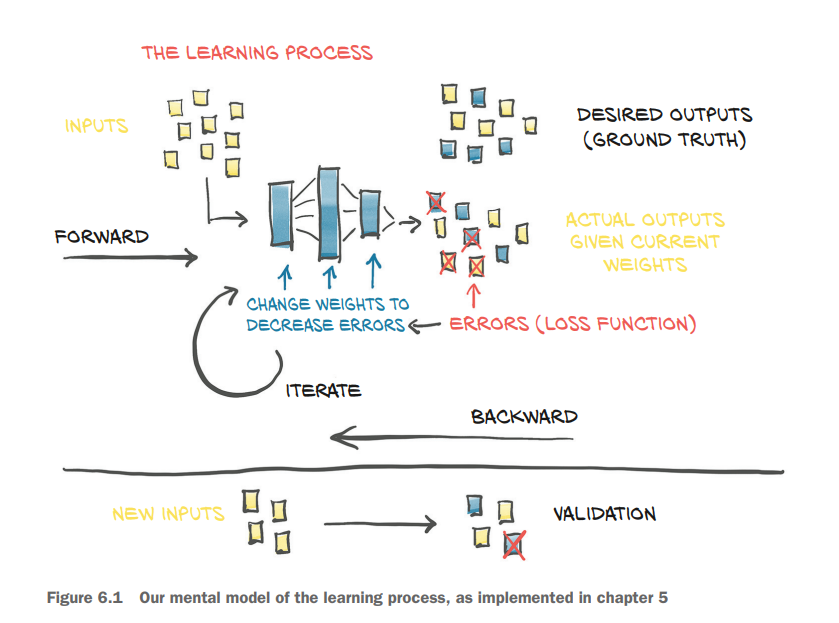

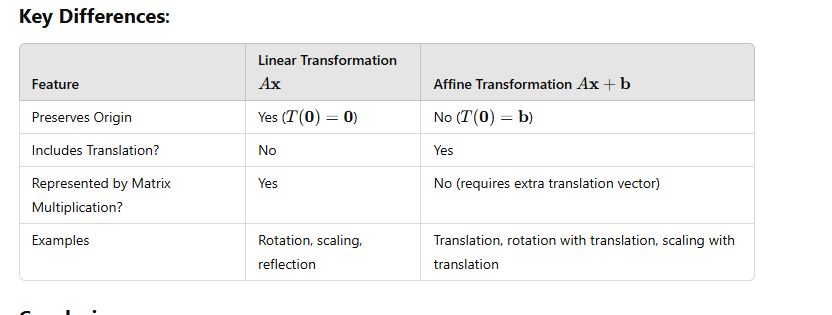

A big part of the reason neural networks have non-convex error surfaces is due to
the activation function. The ability of an ensemble of neurons to approximate a very
wide range of useful functions depends on the combination of the linear and nonlinear behavior inherent to each neuron.

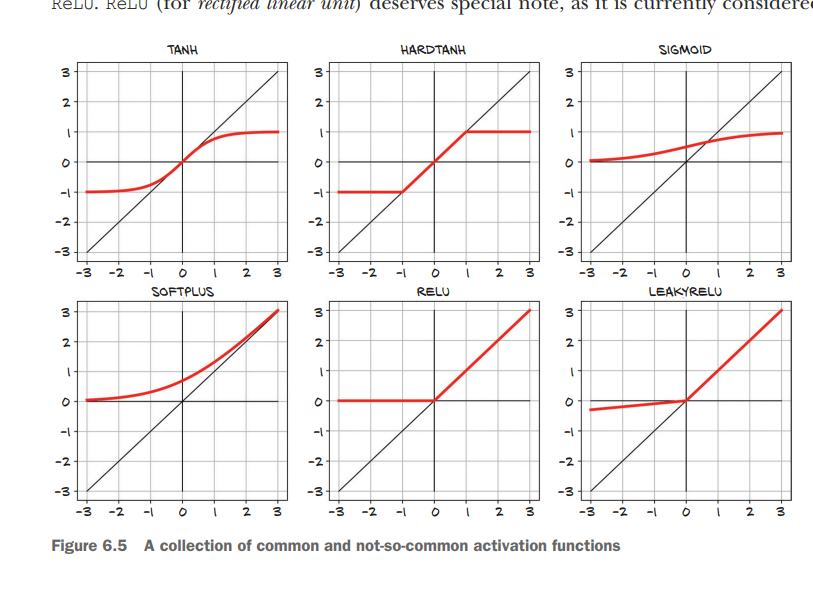

Put together, all this results in a pretty powerful mechanism: we’re saying that in a
network built out of linear + activation units, when different inputs are presented to
the network, (a) different units will respond in different ranges for the same inputs,
and (b) the errors associated with those inputs will primarily affect the neurons operating in the sensitive range, leaving other units more or less unaffected by the learning process.

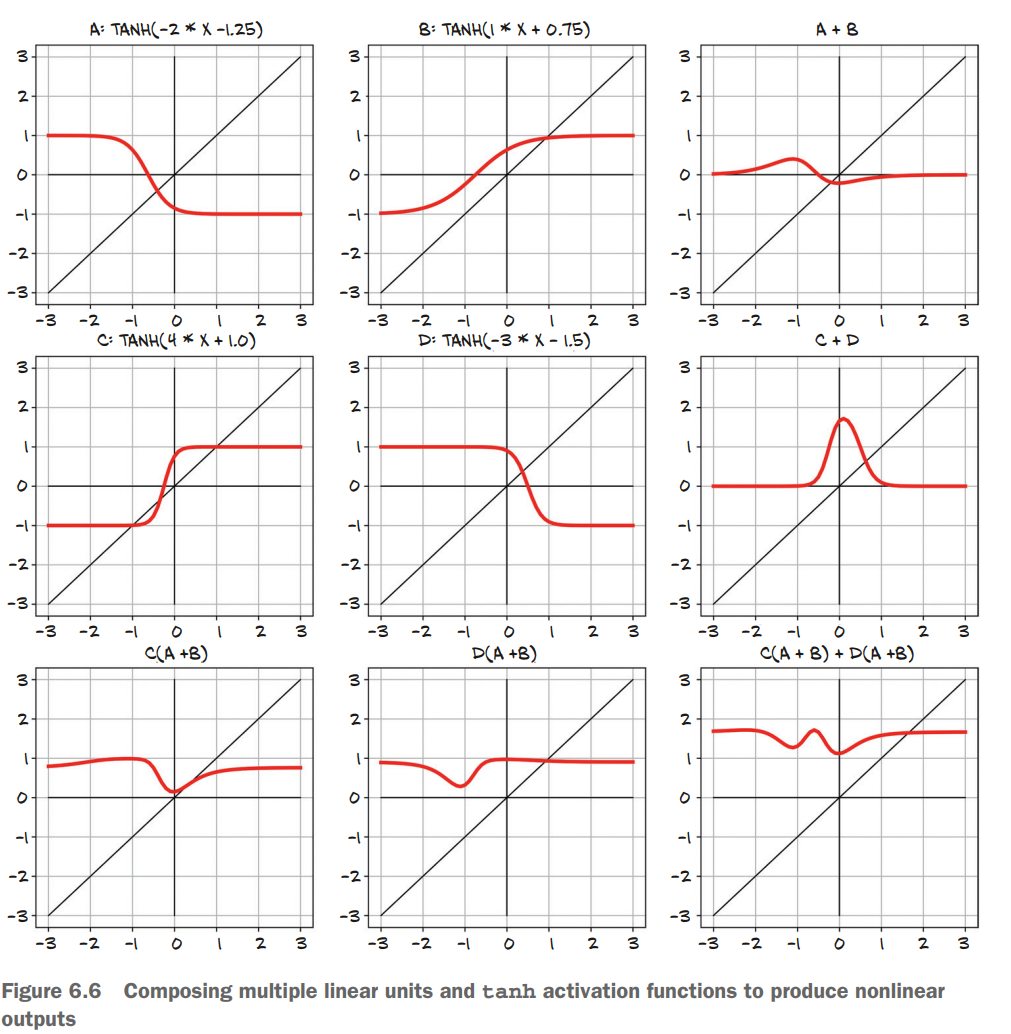

 PyTorch has a whole submodule dedicated to neural networks, called torch.nn. It
contains the building blocks needed to create all sorts of neural network architectures. Those building blocks are called modules in PyTorch parlance (such building
blocks are often referred to as layers in other frameworks). A PyTorch module is a
Python class deriving from the nn.Module base class. A module can have one or more
Parameter instances as attributes, which are tensors whose values are optimized
during the training process (think w and b in our linear model). A module can also
have one or more submodules (subclasses of nn.Module) as attributes, and it will be
able to track their parameters as well.


## Using __call__ rather than forward

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 6,  7, 10,  0,  4,  3,  9,  5,  2]), tensor([1, 8]))

In [4]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [5]:
linear_model = nn.Linear(1,1)
linear_model(t_un_val)

tensor([[-0.2447],
        [-0.3221]], grad_fn=<AddmmBackward0>)

Back to our linear model. The constructor to nn.Linear accepts three arguments: the
number of input features, the number of output features, and whether the linear
model includes a bias or not (defaulting to True, here)

In [6]:
linear_model.weight

Parameter containing:
tensor([[0.1032]], requires_grad=True)

In [7]:
linear_model.bias

Parameter containing:
tensor([-0.8215], requires_grad=True)

In [8]:
x = torch.ones(1)
linear_model(x)

tensor([-0.7183], grad_fn=<ViewBackward0>)

Any module in nn is written to produce outputs for a batch of multiple inputs at the
same time. Thus, assuming we need to run nn.Linear on 10 samples, we can create an
input tensor of size B × Nin, where B is the size of the batch and Nin is the number of
input features, and run it once through the model. For example:

In [9]:
x = torch.ones(10,1)
linear_model(x)

tensor([[-0.7183],
        [-0.7183],
        [-0.7183],
        [-0.7183],
        [-0.7183],
        [-0.7183],
        [-0.7183],
        [-0.7183],
        [-0.7183],
        [-0.7183]], grad_fn=<AddmmBackward0>)

In [10]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

In [11]:
t_u.shape

torch.Size([11, 1])

In [12]:
linear_model = nn.Linear(1,1)
optimizer = optim.SGD(
    linear_model.parameters(),
    lr=1e-2
)

In [13]:
linear_model.parameters()

<generator object Module.parameters at 0x7c680df06960>

In [14]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.3255]], requires_grad=True),
 Parameter containing:
 tensor([0.2341], requires_grad=True)]

In [15]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,t_c_train, t_c_val):
  for epoch in range(1,n_epochs+1):
    t_p_train = model(t_u_train)
    loss_train = loss_fn(t_p_train, t_c_train)

    t_p_val = model(t_u_val)
    loss_val = loss_fn(t_p_val, t_c_val)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if epoch == 1 or epoch % 1000 == 0:
      print(f"Epoch {epoch}, Training loss {loss_train.item():.4f}, Validation loss {loss_val.item():.4f}")

In [16]:
linear_model = nn.Linear(1,1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val
)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 369.7615, Validation loss 249.5363
Epoch 1000, Training loss 3.0700, Validation loss 5.7137
Epoch 2000, Training loss 2.5729, Validation loss 4.8507
Epoch 3000, Training loss 2.5643, Validation loss 4.7442

Parameter containing:
tensor([[5.3101]], requires_grad=True)
Parameter containing:
tensor([-16.8499], requires_grad=True)


In [17]:
seq_model = nn.Sequential(
    nn.Linear(1,13),
    nn.Tanh(),
    nn.Linear(13,1)
)

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [18]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [19]:
for name, param in seq_model.named_parameters():
  print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


The name of each module in Sequential is just the ordinal with which the module
appears in the arguments. Interestingly, Sequential also accepts an OrderedDict,
4
 in
which we can name each module passed to Sequential:

In [20]:
from collections import OrderedDict

seq_model = nn.Sequential(
    OrderedDict([
        ('hidden_linear', nn.Linear(1,8)),
        ('hidden_activation', nn.Tanh()),
        ('output_linear', nn.Linear(8,1))
    ])
)

In [21]:
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [22]:
optimizer = optim.SGD(seq_model.parameters(), lr = 1e-3)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val
)

Epoch 1, Training loss 208.1223, Validation loss 120.8059
Epoch 1000, Training loss 5.1475, Validation loss 3.6932
Epoch 2000, Training loss 5.3377, Validation loss 5.8351
Epoch 3000, Training loss 2.9723, Validation loss 2.7795
Epoch 4000, Training loss 2.0477, Validation loss 2.5076
Epoch 5000, Training loss 1.7086, Validation loss 2.7496


In [23]:
print(seq_model(t_un_val))

tensor([[11.0527],
        [ 6.7976]], grad_fn=<AddmmBackward0>)


In [24]:
print(t_c_val)

tensor([[14.],
        [ 6.]])


In [25]:
print(seq_model.hidden_linear.weight.grad)

tensor([[ 16.0948],
        [  0.1340],
        [  0.8115],
        [ 15.7929],
        [ -0.7028],
        [ 16.4897],
        [-15.7285],
        [  0.6304]])


In [26]:
print(seq_model.hidden_linear.weight)

Parameter containing:
tensor([[ 0.4481],
        [ 0.5978],
        [ 0.4280],
        [ 0.4534],
        [-0.3602],
        [ 0.5829],
        [-0.4517],
        [ 0.6607]], requires_grad=True)


In [27]:
from matplotlib import pyplot as plt

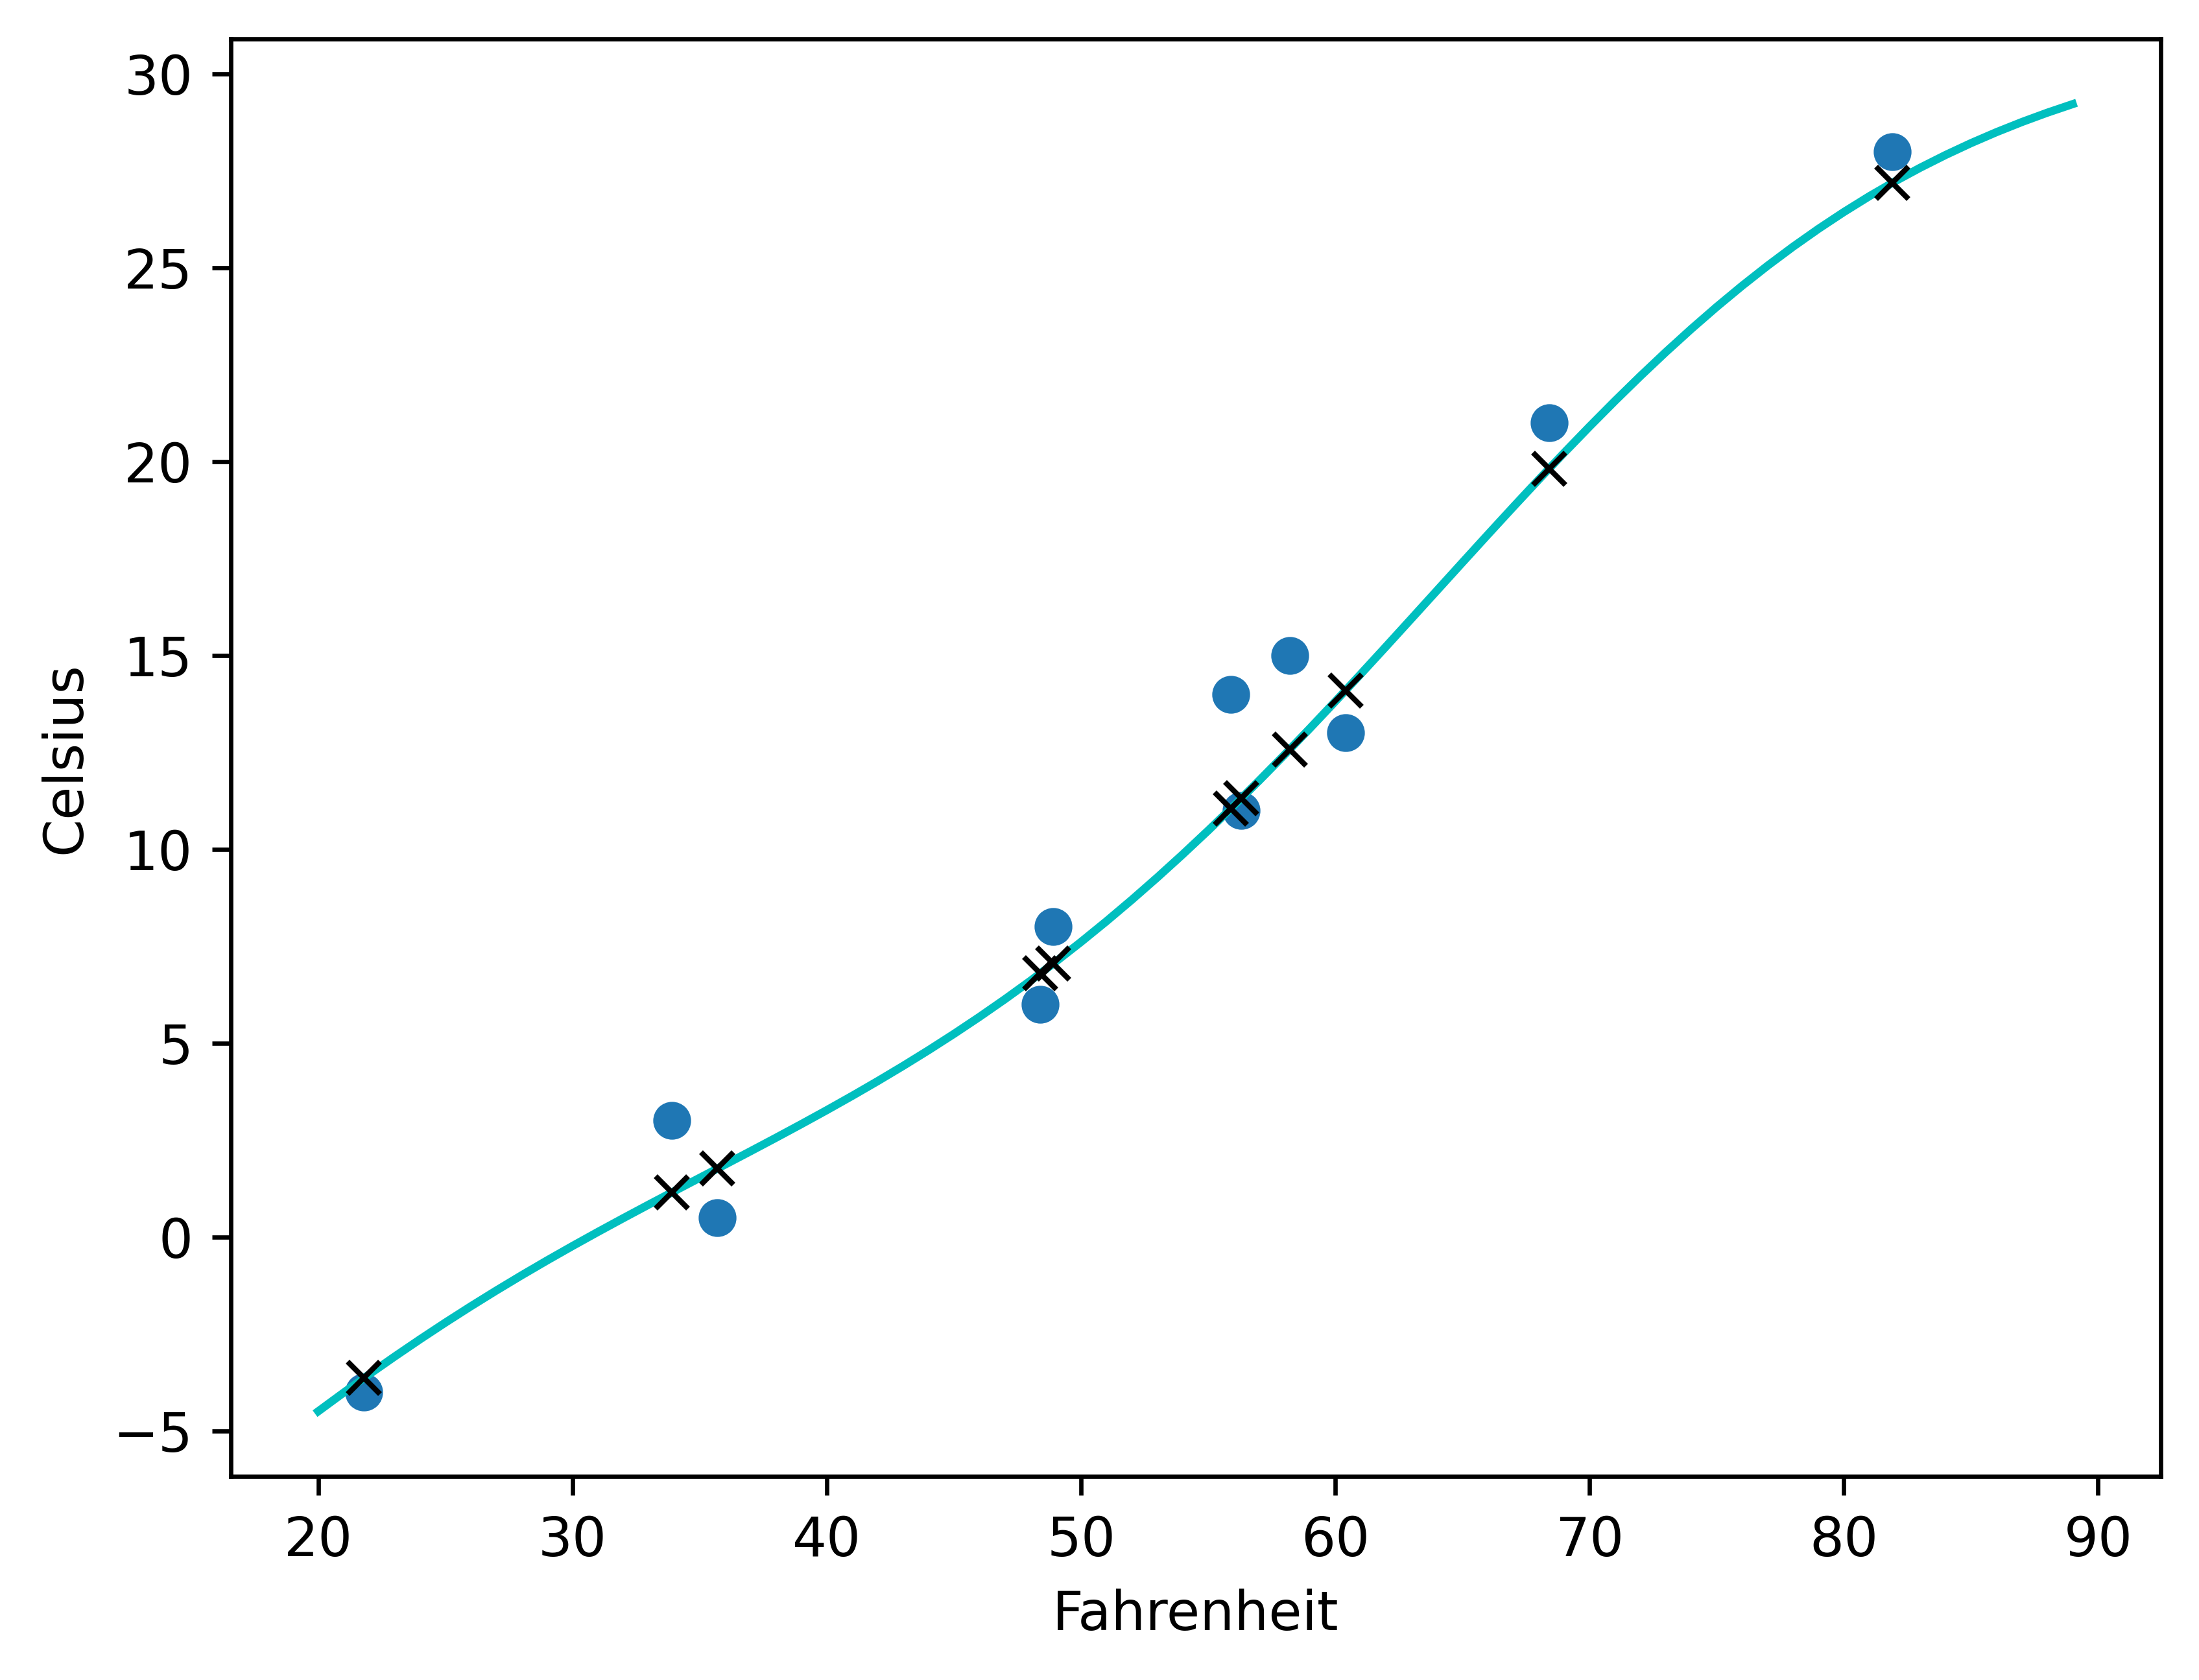

In [28]:
t_range = torch.arange(20.,90.).unsqueeze(1)
fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

## Excersie

In [29]:
import numpy as np

In [31]:
import csv
wine_path = "winequality-white.csv"
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=";",
                         skiprows=1)
wineq_numpy

array([[ 7.  ,  0.27,  0.36, ...,  0.45,  8.8 ,  6.  ],
       [ 6.3 ,  0.3 ,  0.34, ...,  0.49,  9.5 ,  6.  ],
       [ 8.1 ,  0.28,  0.4 , ...,  0.44, 10.1 ,  6.  ],
       ...,
       [ 6.5 ,  0.24,  0.19, ...,  0.46,  9.4 ,  6.  ],
       [ 5.5 ,  0.29,  0.3 , ...,  0.38, 12.8 ,  7.  ],
       [ 6.  ,  0.21,  0.38, ...,  0.32, 11.8 ,  6.  ]], dtype=float32)

In [32]:
wineq = torch.from_numpy(wineq_numpy)

wineq.shape, wineq.dtype

(torch.Size([4898, 12]), torch.float32)

In [33]:
data = wineq[:,:-1]
data, data.shape

(tensor([[ 7.0000,  0.2700,  0.3600,  ...,  3.0000,  0.4500,  8.8000],
         [ 6.3000,  0.3000,  0.3400,  ...,  3.3000,  0.4900,  9.5000],
         [ 8.1000,  0.2800,  0.4000,  ...,  3.2600,  0.4400, 10.1000],
         ...,
         [ 6.5000,  0.2400,  0.1900,  ...,  2.9900,  0.4600,  9.4000],
         [ 5.5000,  0.2900,  0.3000,  ...,  3.3400,  0.3800, 12.8000],
         [ 6.0000,  0.2100,  0.3800,  ...,  3.2600,  0.3200, 11.8000]]),
 torch.Size([4898, 11]))

In [34]:
target = wineq[:,-1].long()
target, target.shape

(tensor([6, 6, 6,  ..., 6, 7, 6]), torch.Size([4898]))

In [35]:
target_onehot = torch.zeros(target.shape[0], 10)

target_onehot.shape

torch.Size([4898, 10])

In [36]:
target_onehot.scatter(1, target.unsqueeze(1),1.0)

target_onehot.shape

torch.Size([4898, 10])

In [37]:
target_onehot

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [38]:
target_unsqueezed = target.unsqueeze(1)
target_unsqueezed.shape

torch.Size([4898, 1])

In [39]:
data.shape

torch.Size([4898, 11])

In [40]:
target_onehot.shape

torch.Size([4898, 10])

In [41]:
n_samples = data.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([4762, 2911, 1412,  ..., 2700, 3139, 1019]),
 tensor([2081, 2710,  775, 4871,  630, 4363, 3838, 4825, 2587, 3494,  126, 1059,
          108, 2392, 4239,  911, 4288, 3965, 2783, 4530, 4756, 4758, 1549, 3345,
         3619, 3126, 2412, 1954,  534, 3135, 3069, 3734, 3703,  838, 2006, 4232,
         1971, 1674, 4794, 3310,  566, 2475,   15, 4544,  616,  916,  381, 4689,
         2376,  505, 2887, 2261, 3330,  573, 3999, 1702, 4610, 4049,  518, 1038,
         2490, 4709,  990, 3932, 2484, 4584, 4754,  739,  865, 2870,  570,  894,
         3501, 2479, 2512, 2378, 1550, 4734,  277, 2433, 4245, 4851,  822, 3213,
          531, 4571, 1750, 1470,  605, 3108,  878, 3403, 1431,  893, 1692, 4067,
         2670, 2274, 2639, 1165, 4226, 3868,  786,  795, 4144, 3155,  832, 4117,
         1142, 2414, 1639,  784, 4895, 1635, 3617, 1996, 4764, 2089, 3948, 3664,
         4811,  434, 3872, 1084,  921, 3076, 1422, 1684, 4418,  214, 2718, 4342,
         2156,  664,  825,  278, 4759,  414,  624, 3364,

In [42]:
train_X = data[train_indices]
train_Y = target_onehot[train_indices]

val_X = data[val_indices]
val_Y = target_onehot[val_indices]

train_X.shape, train_Y.shape, val_X.shape, val_Y.shape

(torch.Size([3919, 11]),
 torch.Size([3919, 10]),
 torch.Size([979, 11]),
 torch.Size([979, 10]))

In [43]:
train_Y_indices = torch.argmax(train_Y, dim=1)
val_Y_indices = torch.argmax(val_Y, dim=1)

In [49]:
model = nn.Sequential(
    nn.Linear(11,20),
    nn.ReLU(),
    nn.Linear(20,10),
    nn.ReLU()
)

In [50]:
model

Sequential(
  (0): Linear(in_features=11, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=10, bias=True)
  (3): ReLU()
)

In [51]:
def loss_fn(predictions, actual):
  return nn.CrossEntropyLoss()(predictions,actual)

optimizer = optim.SGD(model.parameters(), lr=1e-2)

In [52]:
def training_loop(n_epochs, optimizer, model, loss, train_X, train_Y,val_X,val_Y):
  for epoch in range(1,n_epochs+1):
    train_t_p = model(train_X)
    loss_train = loss(train_t_p, train_Y)

    with torch.no_grad():
      val_t_p = model(val_X)
      loss_val = loss(val_t_p, val_Y)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if epoch == 1 or epoch % 1000 == 0:
      print(f"Epoch {epoch}, Training loss {loss_train.item():.4f}, Validation loss {loss_val.item():.4f}")

In [53]:
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = model,
    loss = loss_fn,
    train_X = train_X,
    train_Y = train_Y_indices,
    val_X = val_X,
    val_Y = val_Y_indices
)

Epoch 1, Training loss 15.0037, Validation loss 14.8815
Epoch 1000, Training loss 0.0005, Validation loss 0.0000
Epoch 2000, Training loss 0.0003, Validation loss 0.0000
Epoch 3000, Training loss 0.0002, Validation loss 0.0000
Epoch 4000, Training loss 0.0001, Validation loss 0.0000
Epoch 5000, Training loss 0.0001, Validation loss 0.0000


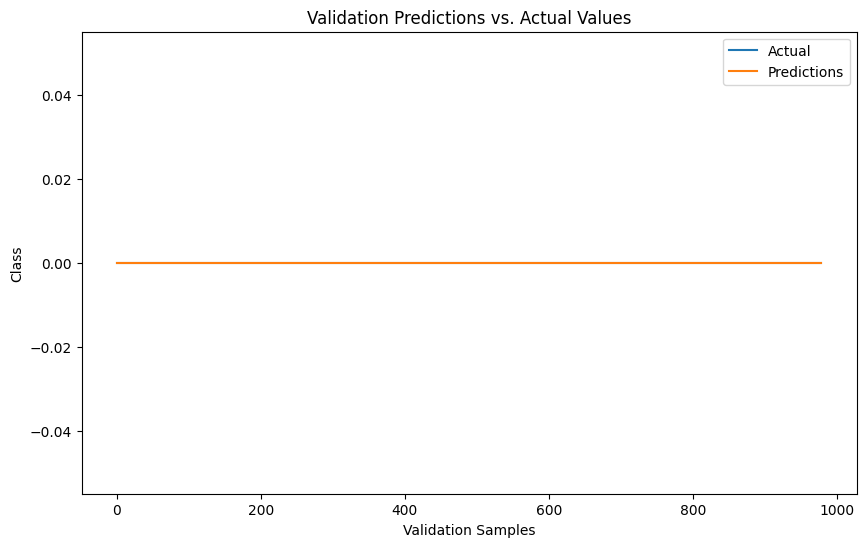

In [54]:
# prompt: plot the predictions on validation against the actual values for the val_Y dataset

with torch.no_grad():
  val_predictions = model(val_X)
  predicted_classes = torch.argmax(val_predictions, dim=1)
  actual_classes = val_Y_indices

plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(actual_classes)), actual_classes.numpy(), label='Actual')
plt.plot(np.arange(len(predicted_classes)), predicted_classes.numpy(), label='Predictions')
plt.xlabel('Validation Samples')
plt.ylabel('Class')
plt.title('Validation Predictions vs. Actual Values')
plt.legend()
plt.show()

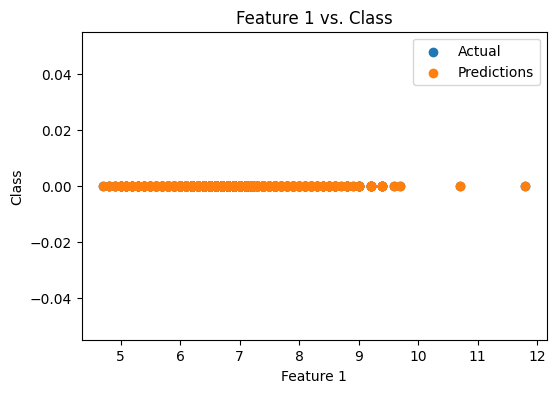

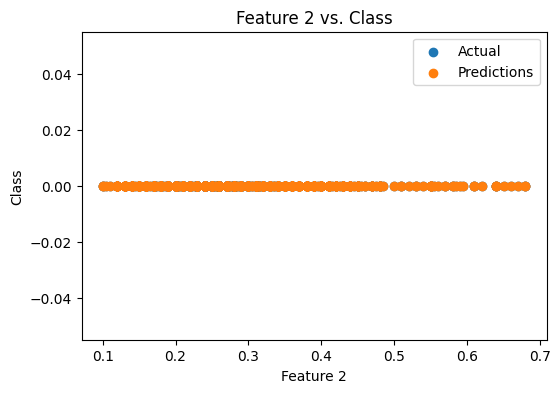

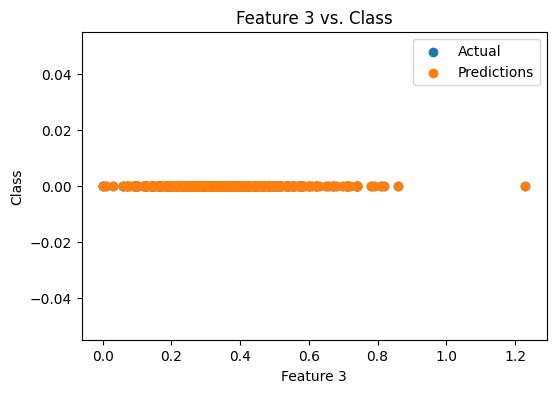

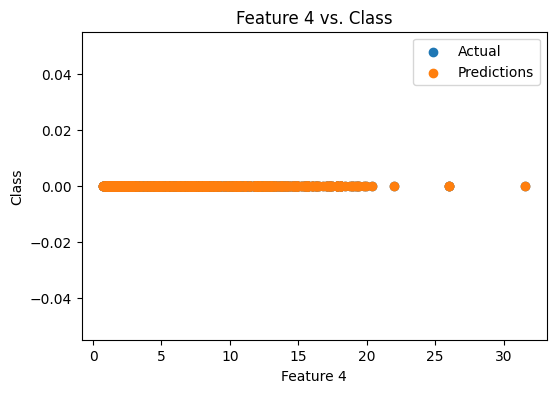

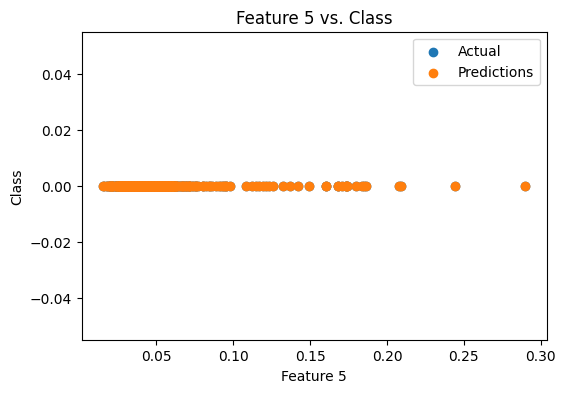

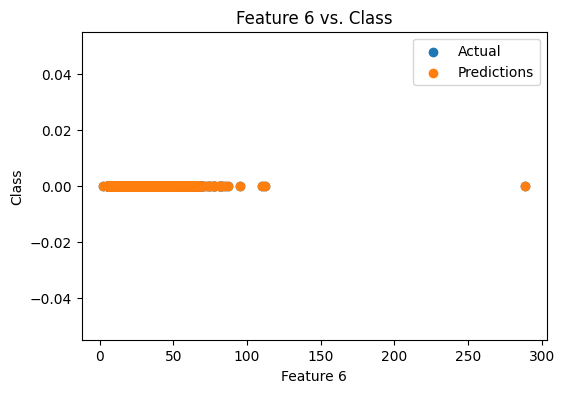

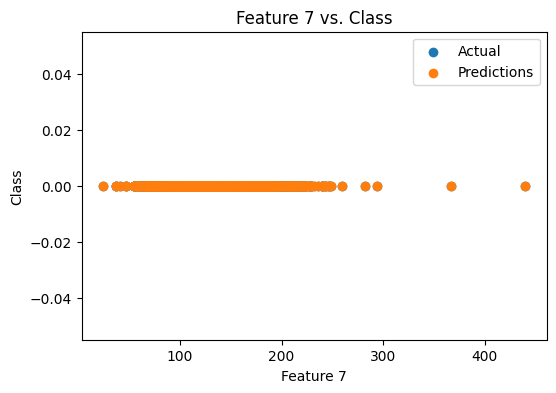

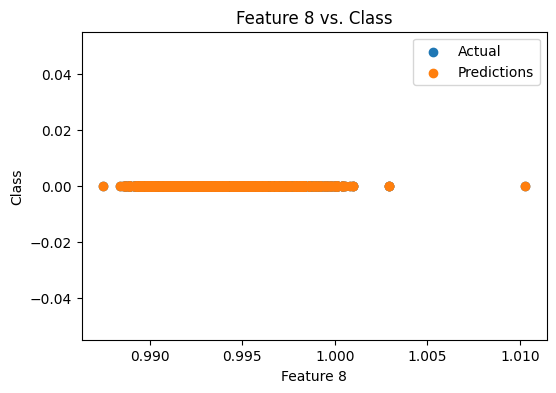

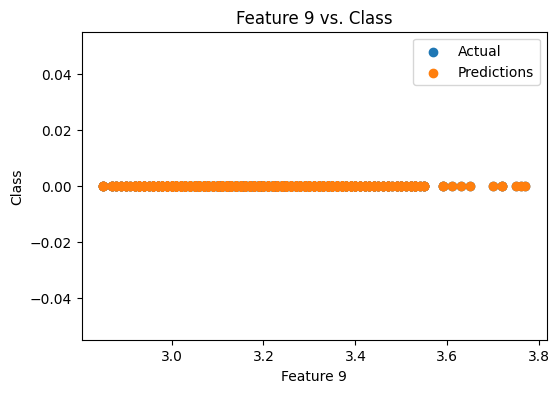

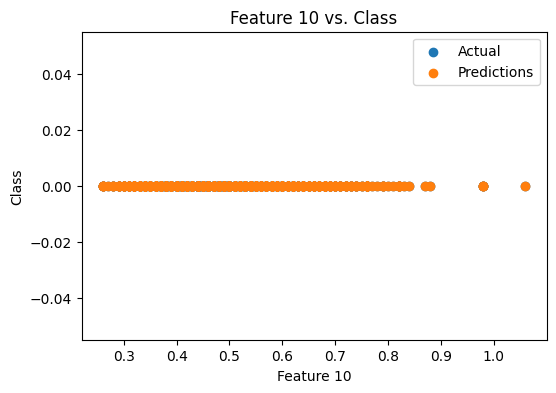

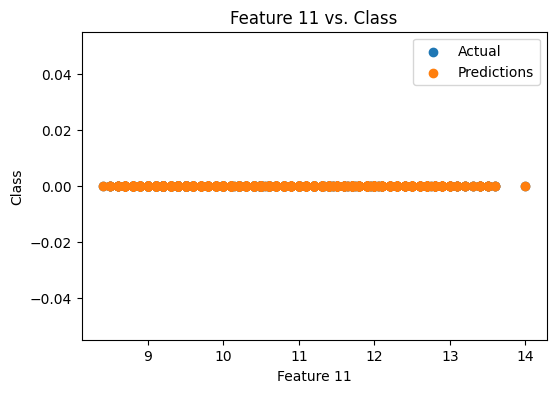

In [55]:
# prompt: come up with a way to plot the factors (input features) with the labels

with torch.no_grad():
  val_predictions = model(val_X)
  predicted_classes = torch.argmax(val_predictions, dim=1)
  actual_classes = val_Y_indices

# Create a scatter plot for each feature against the label
for i in range(val_X.shape[1]):
  plt.figure(figsize=(6, 4))
  plt.scatter(val_X[:, i].numpy(), actual_classes.numpy(), label='Actual')
  plt.scatter(val_X[:, i].numpy(), predicted_classes.numpy(), label='Predictions')
  plt.xlabel(f'Feature {i + 1}')
  plt.ylabel('Class')
  plt.title(f'Feature {i + 1} vs. Class')
  plt.legend()
  plt.show()


In [56]:
# prompt: calculate the accuray, f1, precision, recall for the predictions

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

with torch.no_grad():
  val_predictions = model(val_X)
  predicted_classes = torch.argmax(val_predictions, dim=1)
  actual_classes = val_Y_indices

accuracy = accuracy_score(actual_classes, predicted_classes)
f1 = f1_score(actual_classes, predicted_classes, average='weighted')
precision = precision_score(actual_classes, predicted_classes, average='weighted')
recall = recall_score(actual_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 1.0
F1 Score: 1.0
Precision: 1.0
Recall: 1.0
